## Generate Fasion Images with Conditional GAN

목표: 레이블 조건을 입력해 원하는 클래스를 생성하는 Conditional GAN(cGAN)을 MNIST/Fashion-MNIST로 학습합니다.

구성: 환경 준비 → 하이퍼파라미터 → 데이터 로더 → 유틸 → MLP cGAN / DCGAN형 cDCGAN 모델 → 손실/옵티마이저 → 학습 루프 → 시각화/샘플링 → 체크포인트.

선택: 단순 MLP 기반 cGAN 또는 DCGAN 스타일 cDCGAN을 스위치로 선택하며 비교 실험이 가능합니다.

In [1]:
# Python >=3.10, 최신 PyTorch/torchvision 권장
# Colab일 경우 주석 해제하여 최신 버전 설치 가능
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import math
import time
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("torch:", torch.__version__, "torchvision:", torchvision.__version__)


Device: cuda
torch: 2.8.0+cu126 torchvision: 0.23.0+cu126


최신 PyTorch/torchvision 환경에서 실행되는지 출력으로 확인합니다.

Colab에서 CUDA 최신 빌드를 쓰려면 주석을 해제해 업데이트할 수 있습니다.

device를 자동 선택해 GPU 사용을 최대화합니다.

torch.cuda.is_available()로 GPU 사용 가능 여부를 확인합니다.

torchvision.utils의 make_grid/save_image는 미리보기 그리드 및 이미지 저장에 사용됩니다.



In [2]:
class Cfg:
    # 데이터셋: mnist | fashion
    dataset = "mnist"
    data_dir = "./data"
    img_size = 28
    img_channels = 1
    num_classes = 10

    # 모델 선택: "mlp" 또는 "dcgan"
    model_type = "dcgan"  # "mlp"로 바꿔 비교 가능

    # 학습
    batch_size = 128
    epochs = 20
    lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999

    # 잠재공간
    nz = 100
    embed_dim = 50  # 레이블 임베딩 차원(조건 주입)

    # DCGAN 채널 크기
    ngf = 64
    ndf = 64

    # 손실/라벨 스무딩
    label_smooth = 0.0  # 0~0.1 정도 권장

    # 로깅/저장
    log_interval = 100
    sample_dir = "./samples"
    ckpt_dir = "./checkpoints"

cfg = Cfg()
os.makedirs(cfg.sample_dir, exist_ok=True)
os.makedirs(cfg.ckpt_dir, exist_ok=True)
cfg


실험에서 자주 바꾸는 항목을 한 곳에 모아 재현성 및 가독성을 높입니다.

model_type으로 “mlp”와 “dcgan”을 선택해 두 모델을 손쉽게 비교할 수 있습니다.

label_smooth 등 GAN 안정화 옵션을 하이퍼파라미터화합니다.

lr, betas는 DCGAN에서 흔히 쓰는 설정입니다.

embed_dim은 조건 정보를 얼마나 압축/표현할지 제어합니다.

In [3]:
def get_dataloaders(cfg):
    if cfg.dataset.lower() == "mnist":
        transform = T.Compose([
            T.Resize(cfg.img_size),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])
        trainset = torchvision.datasets.MNIST(
            root=cfg.data_dir, train=True, download=True, transform=transform)
        num_classes = 10
        img_channels = 1
    elif cfg.dataset.lower() == "fashion":
        transform = T.Compose([
            T.Resize(cfg.img_size),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])
        trainset = torchvision.datasets.FashionMNIST(
            root=cfg.data_dir, train=True, download=True, transform=transform)
        num_classes = 10
        img_channels = 1
    else:
        raise ValueError("Unsupported dataset")

    cfg.num_classes = num_classes
    cfg.img_channels = img_channels

    train_loader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_loader

train_loader = get_dataloaders(cfg)
len(train_loader)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.11MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


469

MNIST 또는 Fashion-MNIST를 선택적으로 로드합니다.

픽셀을 [-1, 1] 범위로 정규화해 Tanh 출력과 궁합을 맞춥니다.

DataLoader의 num_workers/pin_memory는 GPU 파이프라인 속도를 높입니다.

Normalize([0.5],[0.5])는 표준 GAN 튜토리얼에서 자주 쓰는 설정입니다.

반환된 len(train_loader)로 데이터 배치 수를 빠르게 확인할 수 있습니다.

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

@torch.no_grad()
def preview_grid(tensor, nrow=10):
    grid = make_grid(denorm(tensor), nrow=nrow)
    return grid

def save_sample(images, path):
    save_image(denorm(images), path, nrow=10)


set_seed로 재현성을 높입니다.

denorm은 시각화를 위해 [-1,1] 이미지를 로 복원합니다.

preview_grid는 이미지 그리드를 생성합니다.

torch.no_grad 데코레이터로 불필요한 그래프 생성을 방지해 메모리 절약합니다.

save_sample은 학습 중간 결과 저장에 사용됩니다.

In [5]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, embed_dim):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)

    def forward(self, y):
        return self.embed(y)


nn.Embedding으로 정수 레이블을 연속 벡터로 임베딩합니다.

임베딩은 모델 내부에서 조건 정보를 압축 표현합니다.

one-hot보다 파라미터 효율적이며 학습 가능한 표현을 제공합니다.

y는 LongTensor여야 합니다.

In [6]:
class MLPGenerator(nn.Module):
    def __init__(self, nz, num_classes, embed_dim, img_size, img_channels):
        super().__init__()
        self.nz = nz
        self.embed = LabelEmbedding(num_classes, embed_dim)
        in_dim = nz + embed_dim
        out_dim = img_size * img_size * img_channels
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.BatchNorm1d(256), nn.ReLU(True),
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(True),
            nn.Linear(1024, out_dim), nn.Tanh()
        )
        self.img_size = img_size
        self.img_channels = img_channels

    def forward(self, z, y):
        e = self.embed(y)
        x = torch.cat([z, e], dim=1)
        out = self.net(x)
        return out.view(out.size(0), self.img_channels, self.img_size, self.img_size)

class MLPDiscriminator(nn.Module):
    def __init__(self, num_classes, embed_dim, img_size, img_channels):
        super().__init__()
        self.embed = LabelEmbedding(num_classes, embed_dim)
        in_dim = img_size * img_size * img_channels + embed_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Linear(1024, 512), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x, y):
        b = x.size(0)
        e = self.embed(y)
        x = x.view(b, -1)
        out = torch.cat([x, e], dim=1)
        return self.net(out).squeeze(1)


### MLP GAN

Generator: z와 y 임베딩을 concat하여 선형층을 거쳐 이미지를 생성합니다.

Discriminator: 입력 이미지와 y 임베딩을 concat하여 진위 스칼라를 예측합니다.

작은 해상도(28×28) 기준으로 간단하고 빠르게 비교 실험할 수 있습니다.

Generator 마지막 활성화는 Tanh로 [-1,1] 범위를 만듭니다.

Discriminator는 로짓을 반환하고 손실에서 sigmoid를 내부적으로 적용합니다.

In [7]:
class CDCGANGenerator(nn.Module):
    def __init__(self, nz, num_classes, embed_dim, ngf, img_channels, img_size=28):
        super().__init__()
        self.nz = nz
        self.embed = LabelEmbedding(num_classes, embed_dim)

        # z+embed -> projection to 7x7 feature map
        proj_dim = nz + embed_dim
        base = 7  # for 28x28
        self.fc = nn.Linear(proj_dim, ngf * 4 * base * base)

        self.main = nn.Sequential(
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  # 7->14
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),    # 14->28
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, img_channels, 3, 1, 1),
            nn.Tanh()
        )

        self.base = base
        self.ngf = ngf

    def forward(self, z, y):
        e = self.embed(y)
        h = torch.cat([z, e], dim=1)
        h = self.fc(h)
        h = h.view(h.size(0), self.ngf*4, self.base, self.base)
        return self.main(h)

class CDCGANDiscriminator(nn.Module):
    def __init__(self, num_classes, embed_dim, ndf, img_channels):
        super().__init__()
        # 조건을 채널로 확장하여 concat
        self.embed = LabelEmbedding(num_classes, embed_dim)
        self.label_to_map = nn.Linear(embed_dim, 28*28)  # for 28x28
        self.img_channels = img_channels

        self.main = nn.Sequential(
            nn.Conv2d(img_channels+1, ndf, 4, 2, 1, bias=False),  # +1 channel for condition map
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False)  # 7x7 -> 1x1
        )

    def forward(self, x, y):
        b = x.size(0)
        e = self.embed(y)                    # (b, embed_dim)
        cond_map = self.label_to_map(e)      # (b, 28*28)
        cond_map = cond_map.view(b, 1, 28, 28)
        x_in = torch.cat([x, cond_map], dim=1)
        out = self.main(x_in).view(b)
        return out


### DCGAN

더 나은 이미지 품질을 위해 ConvTranspose 기반 업샘플을 사용합니다.

Discriminator 쪽에서 조건을 2D 맵으로 확장해 채널 concat합니다.

28×28 기준으로 7×7 base의 업샘플 단계로 구성했습니다.

Cond map은 임베딩을 선형 사상해 이미지 크기와 동일한 2D 채널로 만듭니다.

더 큰 해상도(예: 64×64)로 확장 시 ConvTranspose 블록을 추가하고 cond 맵 크기도 조정하세요.

In [8]:
def build_models(cfg):
    if cfg.model_type == "mlp":
        G = MLPGenerator(cfg.nz, cfg.num_classes, cfg.embed_dim, cfg.img_size, cfg.img_channels).to(device)
        D = MLPDiscriminator(cfg.num_classes, cfg.embed_dim, cfg.img_size, cfg.img_channels).to(device)
    elif cfg.model_type == "dcgan":
        G = CDCGANGenerator(cfg.nz, cfg.num_classes, cfg.embed_dim, cfg.ngf, cfg.img_channels, cfg.img_size).to(device)
        D = CDCGANDiscriminator(cfg.num_classes, cfg.embed_dim, cfg.ndf, cfg.img_channels).to(device)
    else:
        raise ValueError("Unknown model_type")
    return G, D

G, D = build_models(cfg)
sum(p.numel() for p in G.parameters()), sum(p.numel() for p in D.parameters())


(2551477, 180132)

하이퍼파라미터에 따라 MLP 또는 DCGAN 모델을 인스턴스화합니다.

파라미터 수를 간단히 출력해 모델 규모를 파악합니다.

.to(device)로 GPU에 올립니다.

모델 타입 교체만으로 두 구조를 동일한 루프에서 비교할 수 있습니다.

In [9]:
def real_labels(b, smooth=0.0, device="cpu"):
    if smooth > 0:
        return torch.empty(b, device=device).uniform_(1.0 - smooth, 1.0)
    return torch.ones(b, device=device)

def fake_labels(b, device="cpu"):
    return torch.zeros(b, device=device)

criterion = nn.BCEWithLogitsLoss().to(device)
opt_G = torch.optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))


BCEWithLogitsLoss를 사용해 Discriminator 출력 로짓에 안정적으로 적용합니다.

라벨 스무딩을 Real 라벨 측에 선택적으로 적용해 D의 과신을 줄입니다.

Adam 옵티마이저와 DCGAN 권장 betas 설정을 사용합니다.

라벨 스무딩은 0.0~0.1 정도가 일반적입니다.

In [10]:
fixed_z = torch.randn(cfg.num_classes * 10, cfg.nz, device=device)
fixed_y = torch.tensor([c for c in range(cfg.num_classes) for _ in range(10)], device=device)


매 epoch 동일한 z, y로 샘플을 저장해 학습 진척을 일관되게 비교합니다.

각 클래스당 10장씩 총 100장을 그리드로 미리보기 합니다.

고정 템플릿은 모델 성능 비교와 회귀 테스트에 유용합니다.

In [11]:
def train(cfg, G, D, train_loader):
    G.train(); D.train()
    global_step = 0
    for epoch in range(1, cfg.epochs+1):
        t0 = time.time()
        for i, (real, labels) in enumerate(train_loader):
            real = real.to(device)
            labels = labels.to(device)
            b = real.size(0)

            # 1) Train Discriminator: maximize log(D(x|y)) + log(1 - D(G(z|y)))
            opt_D.zero_grad()
            # real
            out_real = D(real, labels)
            loss_real = criterion(out_real, real_labels(b, cfg.label_smooth, device=device))

            # fake
            z = torch.randn(b, cfg.nz, device=device)
            y = labels
            fake = G(z, y).detach()
            out_fake = D(fake, y)
            loss_fake = criterion(out_fake, fake_labels(b, device=device))

            loss_D = loss_real + loss_fake
            loss_D.backward()
            opt_D.step()

            # 2) Train Generator: maximize log(D(G(z|y))) -> minimize BCE with target 1
            opt_G.zero_grad()
            z = torch.randn(b, cfg.nz, device=device)
            y = labels
            gen = G(z, y)
            out = D(gen, y)
            loss_G = criterion(out, real_labels(b, 0.0, device=device))
            loss_G.backward()
            opt_G.step()

            if global_step % cfg.log_interval == 0:
                print(f"Epoch {epoch}/{cfg.epochs} Step {global_step} | D: {loss_D.item():.3f} (R {loss_real.item():.3f} F {loss_fake.item():.3f}) | G: {loss_G.item():.3f}")
            global_step += 1

        with torch.no_grad():
            G.eval()
            samples = G(fixed_z, fixed_y)
            save_path = os.path.join(cfg.sample_dir, f"epoch_{epoch:03d}.png")
            save_sample(samples, save_path)
            G.train()
        print(f"Epoch {epoch} done in {time.time()-t0:.1f}s, saved {save_path}")

train(cfg, G, D, train_loader)


Epoch 1/20 Step 0 | D: 1.393 (R 0.702 F 0.691) | G: 0.880
Epoch 1/20 Step 100 | D: 1.080 (R 0.546 F 0.534) | G: 1.237
Epoch 1/20 Step 200 | D: 1.121 (R 0.550 F 0.572) | G: 1.179
Epoch 1/20 Step 300 | D: 1.374 (R 0.909 F 0.465) | G: 0.807
Epoch 1/20 Step 400 | D: 1.170 (R 0.523 F 0.647) | G: 1.246
Epoch 1 done in 19.9s, saved ./samples/epoch_001.png
Epoch 2/20 Step 500 | D: 1.165 (R 0.598 F 0.567) | G: 0.990
Epoch 2/20 Step 600 | D: 1.311 (R 0.545 F 0.765) | G: 1.185
Epoch 2/20 Step 700 | D: 1.230 (R 0.749 F 0.481) | G: 0.950
Epoch 2/20 Step 800 | D: 1.141 (R 0.568 F 0.573) | G: 1.264
Epoch 2/20 Step 900 | D: 1.170 (R 0.706 F 0.464) | G: 1.066
Epoch 2 done in 17.2s, saved ./samples/epoch_002.png
Epoch 3/20 Step 1000 | D: 1.139 (R 0.621 F 0.518) | G: 1.096
Epoch 3/20 Step 1100 | D: 0.967 (R 0.530 F 0.437) | G: 1.224
Epoch 3/20 Step 1200 | D: 0.991 (R 0.511 F 0.480) | G: 1.232
Epoch 3/20 Step 1300 | D: 1.306 (R 0.610 F 0.696) | G: 1.385
Epoch 3/20 Step 1400 | D: 0.857 (R 0.424 F 0.432) | 

Discriminator: real와 fake를 번갈아 학습해 판별 성능을 높입니다.

Generator: 생성 이미지를 D가 real로 분류하도록 학습합니다.

주기적으로 손실을 로그로 출력하고, epoch 끝마다 샘플 이미지를 저장합니다.

.detach()로 D 업데이트 시 G를 고정합니다.

Generator 업데이트에서는 target을 1로 두어 D를 속이도록 합니다.

JTUR(두 옵티마이저에 서로 다른 lr) 등 변형도 쉽게 적용 가능합니다.

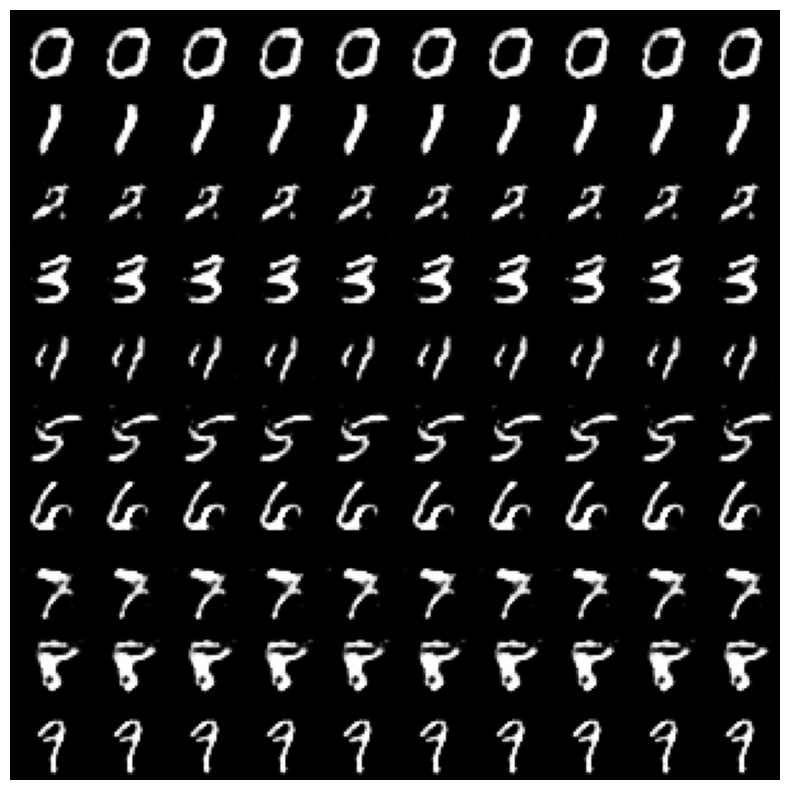

In [12]:
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_fixed(cfg, G):
    G.eval()
    imgs = G(fixed_z, fixed_y).cpu()
    grid = preview_grid(imgs, nrow=10)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

visualize_fixed(cfg, G)


고정 템플릿 이미지 그리드를 시각화합니다.

학습 진행 정도에 따라 숫자 형태가 선명해지는지 직관적으로 확인합니다.

plt.imshow는 CHW → HWC로 바꿔 표시합니다.

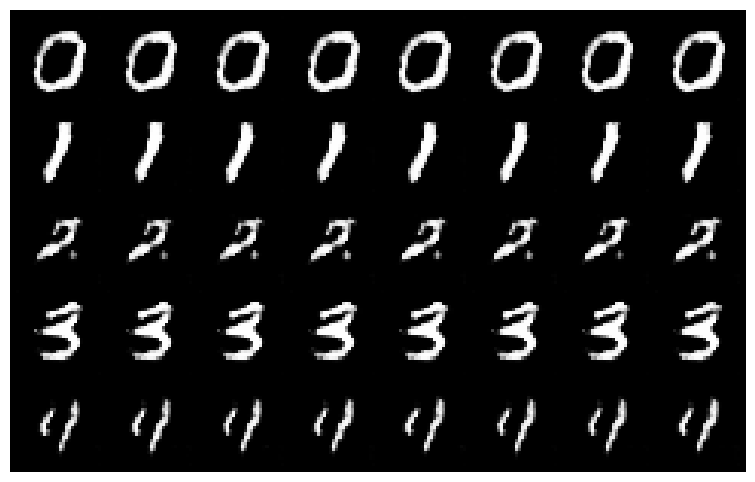

In [13]:
@torch.no_grad()
def sample_classes(cfg, G, classes, n_per_class=8):
    G.eval()
    y = torch.tensor(sum([[c]*n_per_class for c in classes], []), device=device)
    z = torch.randn(len(y), cfg.nz, device=device)
    imgs = G(z, y).cpu()
    grid = preview_grid(imgs, nrow=n_per_class)
    return grid

classes = list(range(cfg.num_classes))[:5]  # 0~4
grid = sample_classes(cfg, G, classes, n_per_class=8)

plt.figure(figsize=(12, 6))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0))
plt.show()


특정 클래스 리스트와 클래스당 샘플 수를 받아 그리드를 생성합니다.

학습된 조건성이 잘 작동하는지 선택적으로 점검할 수 있습니다.

다양한 클래스 조합으로 조건성을 테스트합니다.

fixed 템플릿과 달리 가변 클래스 테스트에 유용합니다.

In [14]:
def save_ckpt(path, G, D, opt_G, opt_D, cfg, epoch):
    state = {
        "G": G.state_dict(),
        "D": D.state_dict(),
        "opt_G": opt_G.state_dict(),
        "opt_D": opt_D.state_dict(),
        "cfg": cfg.__dict__,
        "epoch": epoch
    }
    torch.save(state, path)

def load_ckpt(path, G, D, opt_G=None, opt_D=None, map_location=None):
    state = torch.load(path, map_location=map_location)
    G.load_state_dict(state["G"])
    D.load_state_dict(state["D"])
    if opt_G is not None and "opt_G" in state:
        opt_G.load_state_dict(state["opt_G"])
    if opt_D is not None and "opt_D" in state:
        opt_D.load_state_dict(state["opt_D"])
    return state.get("epoch", None), state.get("cfg", None)

# 저장 예시:
# save_ckpt(os.path.join(cfg.ckpt_dir, "cgan_last.pt"), G, D, opt_G, opt_D, cfg, epoch=cfg.epochs)


장기 학습과 재시작을 위해 모델과 옵티마이저 상태를 저장/복원합니다.

cfg도 함께 저장해 재현성을 높입니다.

In [17]:
epoch, saved_cfg = load_ckpt(os.path.join(cfg.ckpt_dir, "cgan_last.pt"), G, D, opt_G, opt_D, map_location=device)

In [19]:
epoch

20

In [18]:
saved_cfg

{'num_classes': 10, 'img_channels': 1}

장기 실험에서 중단/재개가 쉬워집니다.

saved_cfg로 과거 설정을 확인할 수 있습니다.